# Generate SWAN wave spectra over a scene with currents

### imports

In [1]:
#import wavespectra
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.io as io
from stereoid.oceans.waves.wave_spectra import spec_peak
import netCDF4 as nc
from stereoid.oceans.waves.wave_spectra import elfouhaily

### settings and folder

In [2]:
# path to swan installation
#dir_setup = os.path.join()
swan_dir='/Users/marcelmac/Fortran/swan/swan4131/'

# paths for ocean model
scn_dir =  '/Users/marcelmac/Data/OceanModels/'
scn_file = scn_dir + 'LigurianSea/ligurian_sea_2014-10-07T120000_area_domain.nc'

# path to store the output
output_dir='/Users/marcelmac/Data/Harmony/RESULTS/SWAN/'

### read ocean model output and crop

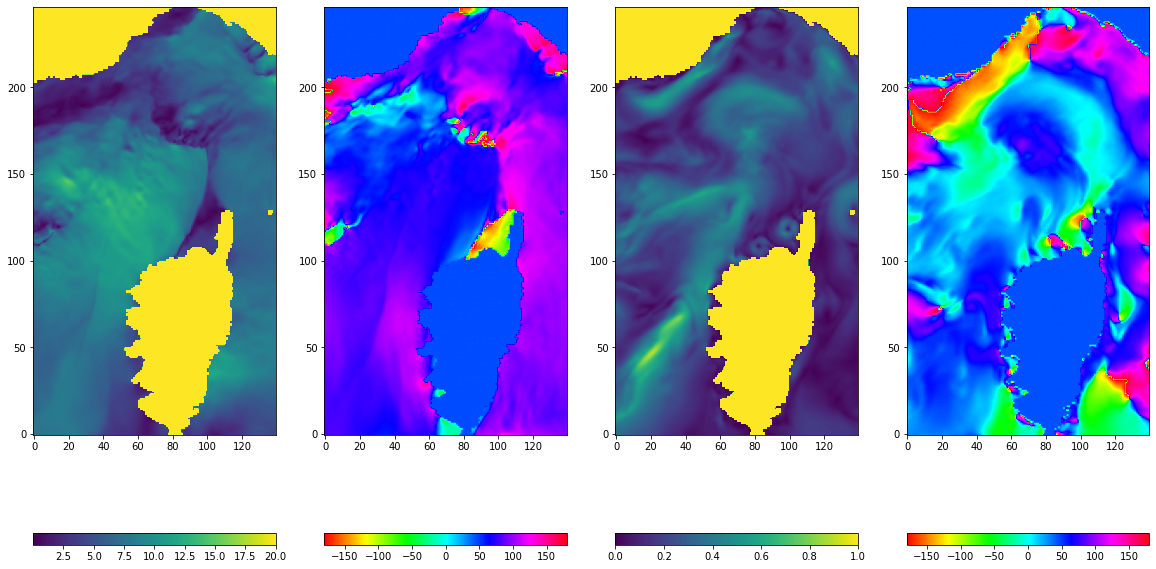

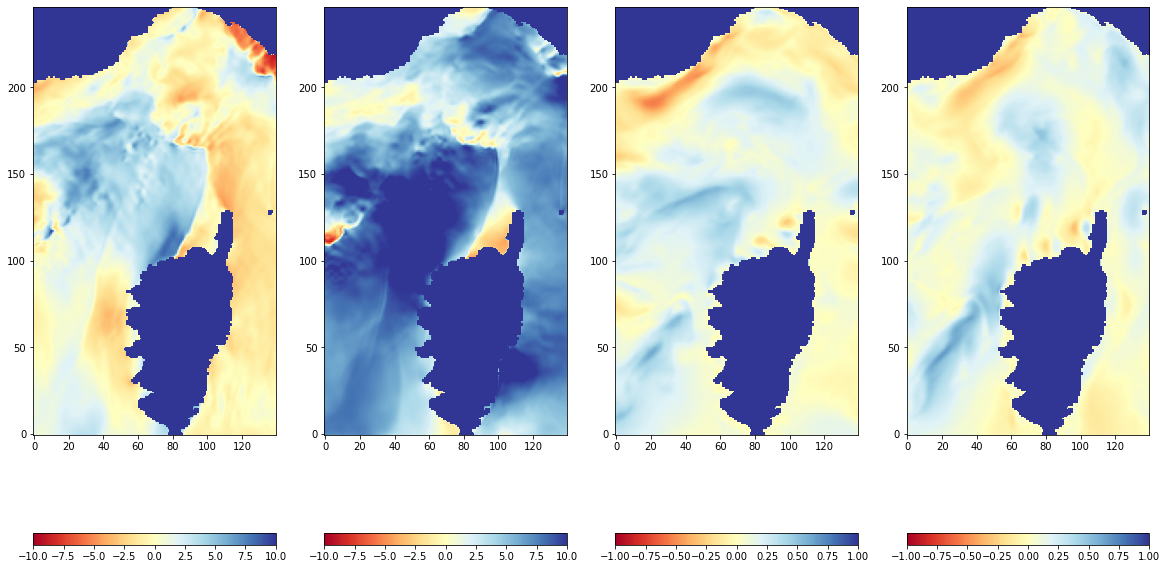

In [3]:
# read data
ds = nc.Dataset(scn_file)
shp=ds['uc'].shape

wind=np.zeros((shp[0],shp[1],2))
tsc=np.zeros((shp[0],shp[1],2))
sst=np.zeros((shp[0],shp[1]))

# atmosphere and ocean parameters
wind[:,:,0]=ds['u10'][:,:]
wind[:,:,1]=ds['v10'][:,:]
tsc[:,:,0]=ds['uc'][:,:]
tsc[:,:,1]=ds['vc'][:,:]
sst=ds['sst'][:,:]

# crop data
Ix=range(50,190)
wind=wind[:,Ix,:]
tsc=tsc[:,Ix,:]
sst=sst[:,Ix]
shp=sst.shape

# x and y (which is a guess)
dx=1000
dy=1000
xs=np.arange(0,shp[1]*dx,dx)
ys=np.arange(0,shp[0]*dy,dy)

# bathymetry
depth=1000
bath=np.ones((shp[0],shp[1]))*depth

# fill in gaps
sst=sst.filled(fill_value=999)
wind[sst==999,0]=999
wind[sst==999,1]=999
tsc[sst==999,0]=999
tsc[sst==999,1]=999
bath[sst==999]=999


plt.figure(figsize=(20,12))
plt.subplot(1,4,1)
plt.imshow(np.sqrt(wind[:,:,0]**2+wind[:,:,1]**2),origin='lower',vmax=20)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,2)
plt.imshow(np.rad2deg(np.arctan2(wind[:,:,1],wind[:,:,0])),vmin=-180,vmax=180, origin='lower',cmap='hsv')
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,3)
plt.imshow(np.sqrt(tsc[:,:,0]**2+tsc[:,:,1]**2),origin='lower',vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,4)
plt.imshow(np.rad2deg(np.arctan2(tsc[:,:,1],tsc[:,:,0])),vmin=-180,vmax=180, origin='lower',cmap='hsv')
plt.colorbar(orientation='horizontal')
plt.figure(figsize=(20,12))
plt.subplot(1,4,1)
plt.imshow(wind[:,:,0],origin='lower',cmap='RdYlBu',vmin=-10,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,2)
plt.imshow(wind[:,:,1], origin='lower',cmap='RdYlBu',vmin=-10,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,3)
plt.imshow(tsc[:,:,0],origin='lower',cmap='RdYlBu',vmin=-1,vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,4)
plt.imshow(tsc[:,:,1], origin='lower',cmap='RdYlBu',vmin=-1,vmax=1)
plt.colorbar(orientation='horizontal')

### generate a SWAN config file

In [4]:
# some required information and intitial settings
g=9.81
fetch=100E3
u10=np.sqrt(wind[:,:,0]**2+wind[:,:,1]**2)
U_mean=np.mean(u10[sst != 999])
phi_w=np.mod(np.rad2deg(np.arctan2(wind[:,:,1],wind[:,:,0])),360)
kp=spec_peak(U_mean,fetch)
f_max=np.sqrt(g*kp*15)/(2*np.pi)
f_min=np.sqrt(g*kp/10)/(2*np.pi)

In [5]:
# some additional initial settings for each segment
k=np.arange(2*np.pi/500,2*np.pi/1,2*np.pi/500)
dk=np.gradient(k)
phi_p=phi_w[:,0]
k_p=spec_peak(u10[:,0],fetch)
f_p=np.sqrt(g*k_p)/(2*np.pi)
p_p=1/f_p
H_p=np.zeros(len(phi_p))
for i in range(0,len(phi_p)):
    S=elfouhaily(k,u10[i,0],fetch)
    H_p[i]=4*np.sqrt(np.sum(S*dk))
dd=20
#plt.plot(k,k**2*S)

I=np.logical_and(sst[:,0] != 999,H_p>0.5)
phi_p=phi_p[I]
p_p=p_p[I]
H_p=H_p[I]
x_p=np.zeros(len(phi_p))
y_p=ys[I]

phi_p2=phi_w[0,:]
k_p2=spec_peak(u10[0,:],fetch)
f_p2=np.sqrt(g*k_p2)/(2*np.pi)
p_p2=1/f_p2
H_p2=np.zeros(len(phi_p2))
for i in range(0,len(phi_p2)):
    S=elfouhaily(k,u10[0,i],fetch)
    H_p2[i]=4*np.sqrt(np.sum(S*dk))

I=np.logical_and(sst[0,:] != 999,H_p2>0.5)
phi_p2=phi_p2[I]
p_p2=p_p2[I]
H_p2=H_p2[I]
x_p2=xs[I]
y_p2=np.zeros(len(phi_p2))

phi_p3=phi_w[:,-1]
k_p3=spec_peak(u10[:,-1],fetch)
f_p3=np.sqrt(g*k_p3)/(2*np.pi)
p_p3=1/f_p3
H_p3=np.zeros(len(phi_p3))
for i in range(0,len(phi_p3)):
    S=elfouhaily(k,u10[i,-1],fetch)
    H_p3[i]=4*np.sqrt(np.sum(S*dk))

I=np.logical_and(sst[:,-1] != 999, H_p3>0.5)
phi_p3=phi_p3[I]
p_p3=p_p3[I]
H_p3=H_p3[I]
x_p3=np.max(xs)*np.ones(len(phi_p3))
y_p3=ys[I]

In [6]:
scene='Lig_'
run= 'R01'
bathfile=output_dir + scene + run + '.bath'
currfile=output_dir + scene + run + '.curr'
windfile=output_dir + scene + run + '.wind'
#inispecfile=output_dir + scene + run + '.inispec'
hsfile=output_dir + 'hs' + scene + run + '.mat'
specfile=output_dir + 'spec' + scene + run + '.xarray'
filename=output_dir + scene + run + '.swn'
f=open(filename,'w+')
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('PROJECT \'%s\' \'%s\'\n' % (scene,run))
f.write('SET CART\n')
f.write('MODE STAT TWOD\n')
f.write('COORDINATES CART\n')
f.write('$---------------------------------------------------------------------------------------------\n')
#f.write('CGRID REG %d %d %d %d %d %d %d CIR %d %.4f %.4f %d\n' % (0,0,0,np.max(xs),np.max(ys),len(xs)-1,len(ys)-1,20,f_min,f_max,40))
f.write('CGRID REG %d %d %d %d %d %d %d SEC %d %d %d %.4f %.4f %d\n' % (0,0,0,np.max(xs),np.max(ys),len(xs)-1,len(ys)-1,-180,180,60,f_min,f_max,96))
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('INP BOT %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('INP CUR %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('INP WI %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('READ BOT 1 \'%s\' 3 0 FREE\n' % bathfile)
f.write('READ CUR 1 \'%s\' 3 0 FREE\n' % currfile)
f.write('READ WI 1 \'%s\' 3 0 FREE\n' % windfile)
#f.write('WIND %.2f %.2f\n' % (U_in,phi_U))
f.write('$---------------------------------------------------------------------------------------------\n')
#f.write('BOUN SEGM XY %d %d %d %d CON FILE \'%s\' 1\n' % (0,0,0,np.max(ys),inispecfile))
f.write('BOU SHAP JON 3.3 PEAK DSPR DEGR\n')
for i in range(0,len(phi_p)): 
    f.write('BOU SEGM XY %d %d VAR PAR 10000 %.2f %.2f %.2f %.2f\n' % (x_p[i], y_p[i], H_p[i], p_p[i], phi_p[i], dd))
for i in range(0,len(phi_p2)): 
    f.write('BOU SEGM XY %d %d VAR PAR 10000 %.2f %.2f %.2f %.2f\n' % (x_p2[i], y_p2[i], H_p2[i], p_p2[i], phi_p2[i], dd))
for i in range(0,len(phi_p3)): 
    f.write('BOU SEGM XY %d %d VAR PAR 10000 %.2f %.2f %.2f %.2f\n' % (x_p3[i], y_p3[i], H_p3[i], p_p3[i], phi_p3[i], dd))
#f.write('BOU SEGM XY %d %d %d %d VAR PAR 50000 %.2f %.2f %.2f %.2f\n' % (0, 0, 0, 100E3, Hs1, per1, phi1, dd1))
#f.write('BOU SEGM XY %d %d %d %d VAR PAR 50000 %.2f %.2f %.2f %.2f\n' % (0, 0, 100E3, 0, Hs2, per2, phi2, dd2))
#f.write('BOU SEGM XY %d %d %d %d VAR PAR 50000 %.2f %.2f %.2f %.2f\n' % (150E3, 0, np.max(xs), 0, Hs3, per3, phi3, dd3))
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('GROUP \'OUTPUT\' SUBG %d %d %d %d\n' % (0,len(xs)-1,0,len(ys)-1))
f.write('BLOCK \'OUTPUT\' NOHEAD \'%s\' LAY 3 HS\n' % hsfile)
f.write('SPEC \'OUTPUT\' SPEC2D ABS \'%s\'\n' % specfile)
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('COMPUTE\n')
f.write('STOP\n')
f.close()

### current, bathymetry and initial spectrum

In [7]:
# current file
tsc_stack=np.vstack((tsc[:,:,0]*1,tsc[:,:,1]*1))
np.savetxt(currfile,tsc_stack,fmt='%.2f')
# bath file
np.savetxt(bathfile,bath,fmt='%.2f')
# wind file
wind_stack=np.vstack((wind[:,:,0]*1,wind[:,:,1]*1))
#phi_rad=np.deg2rad(phi_U)
#wind_stack=np.vstack((np.ones(wind[:,:,0].shape)*10,np.ones(wind[:,:,0].shape)*0))
np.savetxt(windfile,wind_stack,fmt='%.2f')
# optional file for initial wave spectrum
### --------

### run SWAN

In [ ]:
os.chdir(output_dir)
os.system('chmod 755 ./*')
comm='cp ./' + scene + '* ' + swan_dir
os.system(comm)
os.chdir(swan_dir)
comm='./swanrun -input \'' + filename + '\''
print(comm)
os.system(comm)

./swanrun -input '/Users/marcelmac/Data/Harmony/RESULTS/SWAN/Lig_R01.swn'
swan.exe is /Users/marcelmac/Fortran/swan/swan4131/./swan.exe

 SWAN is preparing computation

 iteration    1; sweep 1
+iteration    1; sweep 2
+iteration    1; sweep 3
+iteration    1; sweep 4
 not possible to compute, first iteration

 iteration    2; sweep 1
+iteration    2; sweep 2
+iteration    2; sweep 3
+iteration    2; sweep 4
 accuracy OK in  23.66 % of wet grid points ( 99.50 % required)

 iteration    3; sweep 1
+iteration    3; sweep 2
+iteration    3; sweep 3
+iteration    3; sweep 4
 accuracy OK in   0.17 % of wet grid points ( 99.50 % required)

 iteration    4; sweep 1
+iteration    4; sweep 2
+iteration    4; sweep 3
+iteration    4; sweep 4
 accuracy OK in   4.77 % of wet grid points ( 99.50 % required)

 iteration    5; sweep 1
+iteration    5; sweep 2
+iteration    5; sweep 3
+iteration    5; sweep 4
 accuracy OK in   5.30 % of wet grid points ( 99.50 % required)

 iteration    6; sweep 1
+it

### read wave spectra, significant wave height and do some tests

In [ ]:
hsfile=output_dir + 'hs' + scene + run + '.mat'
#specfile=output_dir + 'spec' + scene + run + '.xarray'
hsdata=io.loadmat(hsfile)

In [ ]:
plt.figure(figsize=(5,15))
plt.imshow(hsdata['Hsig'],origin='lower',vmin=0,vmax=2)
plt.colorbar(orientation='horizontal')
plt.xlabel('cross-track [km]')
plt.ylabel('along-track [km]')
plt.title('SWAN')

In [ ]:
np.any(tsc!=tsc)